### Loading PACE Data

Went to Nasa's Earth Data website https://search.earthdata.nasa.gov/ to download data. 

- searched 'PACE'
-  put it temporal range
-  hit downlaod all... Harmony did not work for me
-  downloaded Earthdata Download in order to create a .zip file

In [8]:
import os, re
import numpy as np
import pandas as pd
import xarray as xr

# find all files with 0.1 deg resolution
folder = "chla_EC_20240907_20241111_PACE"
items = [f for f in os.listdir(folder) if f.endswith("0p1deg.nc")]
files = [os.path.join(folder, f) for f in items]

### Helpers

In [15]:


date_re = re.compile(r'\.(\d{8})_(\d{8})\.')  # e.g. ...20240905_20240912...

def parse_time_from_attrs(ds):
    """Return midpoint between time_coverage_start and end as numpy datetime64."""
    try:
        t0 = pd.to_datetime(ds.attrs.get("time_coverage_start"), utc=True, errors="coerce")
        t1 = pd.to_datetime(ds.attrs.get("time_coverage_end"),   utc=True, errors="coerce")
        if pd.isna(t0) or pd.isna(t1):
            return None
        return (t0 + (t1 - t0)/2).to_datetime64()
    except Exception:
        return None

def parse_time_from_name(path):
    """Fallback: parse YYYYMMDD_YYYYMMDD from filename and return midpoint."""
    try:
        m = date_re.search(os.path.basename(path))
        if not m:
            return None
        t0 = pd.to_datetime(m.group(1), format="%Y%m%d", utc=True)
        t1 = pd.to_datetime(m.group(2), format="%Y%m%d", utc=True)
        return (t0 + (t1 - t0)/2).to_datetime64()
    except Exception:
        return None

def file_midpoint_time(path):
    """Peek at attrs to get midpoint; fall back to filename parse."""
    try:
        with xr.open_dataset(path, decode_times=False) as ds0:
            t = parse_time_from_attrs(ds0)
    except Exception:
        t = None
    return t if t is not None else parse_time_from_name(path)

# preprocess: add a singleton 'time' coord; also drop static vars like 'palette'
def add_time_and_clean(ds, this_file):
    t = parse_time_from_attrs(ds)
    if t is None:
        t = parse_time_from_name(this_file or "")
    if t is None:
        raise ValueError(f"Could not infer time for {this_file}")
    if "time" not in ds.dims:
        ds = ds.expand_dims(time=[t])
    else:
        ds = ds.assign_coords(time=[t])
    if "palette" in ds.variables:
        ds = ds.drop_vars("palette")
    return ds

def _preprocess(ds):
    src = ds.encoding.get("source", "")
    return add_time_and_clean(ds, src)


### plot chlorophyll

In [19]:
# sort by midpoint time
files_sorted = sorted(files, key=file_midpoint_time)

# load & concatenate
ds = xr.open_mfdataset(
    files_sorted,
    combine="nested",          # control order via files_sorted
    concat_dim="time",
    preprocess=_preprocess,
    coords="minimal",
    data_vars="minimal",
    compat="override",
)

In [20]:
lat_rng = slice(42, 25)     
lon_rng = slice(-82, -65)   

sliced = ds.sel(lat=lat_rng, lon=lon_rng)




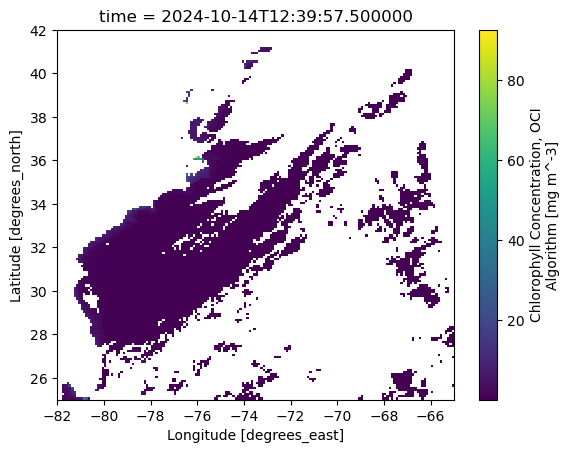

In [23]:
sliced.chlor_a.isel(time=5).plot(x='lon')

**Resources:**

https://github.com/oceanhackweek/ohw24_proj_pace_us/blob/main/final_notebooks/Hypercoast(PACE)_with_IFCB.ipynb

bEast Coast dates


sep 7th - nov 11th

